In [1]:
from autoencoder import generate_autoencoder

In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras
import seaborn as sns

In [3]:
# Heavy Decoder:
#BEST MODEL: L27_E22_20_B16_D18_20_22_24

In [3]:
df = pd.read_csv('../Combined_AM_Data.csv')
all_pid = list(df['id'].unique())
len(all_pid)

26

In [4]:
columns_needed = ['income', 'road_dist', 'cooking', 'y_am_pef', 'tempin', 
                    'humidin', 'pm25in', 'co2in', 'tempdiffin', 'humidiffin', 
                    'pm25diffin', 'pm10', 'pm25', 'o3', 'no2', 'co', 'so2', 'temp', 
                    'windsd', 'humid', 'varp', 'dewpt', 'airp', 'seap', 'solrhr', 'solramnt', 'grdt', 'class']

cleaned_df = df.filter(columns_needed)
all_patients_df = cleaned_df.dropna()

minority_class = all_patients_df[all_patients_df['class'] == 0]
X_train = minority_class.drop('class', axis=1)

In [5]:
INPUT_SHAPE = X_train.shape[1]
X_train.shape

(1137, 27)

In [6]:
MODEL_NAME  = 'L27_E22_20_B16_D18_20_22_24'
encoder_dense_layers = [22, 20]
bottle_neck = 16
decoder_dense_layers = [18, 20, 22, 24]

In [7]:
autoencoder, encoder, decoder = generate_autoencoder(input_shape= INPUT_SHAPE, encoder_dense_layers=encoder_dense_layers,
                                    bottle_neck= bottle_neck, decoder_dense_layers = decoder_dense_layers)

Generating model structure
MODEL:  [22, 20] 16 [18, 20, 22, 24] sigmoid


In [8]:
opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(opt, loss="mse")

In [10]:
history = autoencoder.fit(X_train, X_train, epochs=200, batch_size=16, validation_split=0.25, verbose=0)

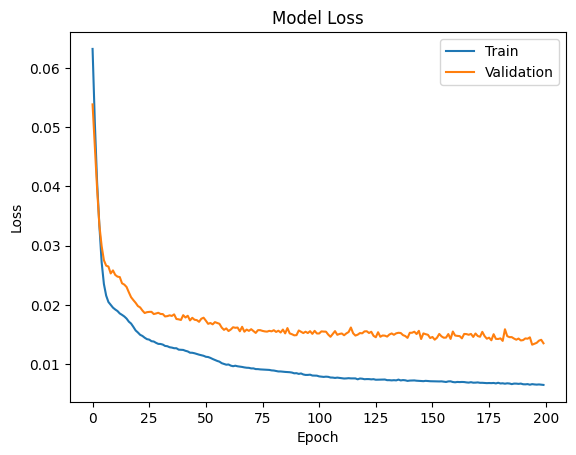

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [12]:
generated_data = autoencoder.predict(X_train)
reshaped_data = generated_data.reshape(len(X_train), -1)
df_generated = pd.DataFrame(reshaped_data, columns=X_train.columns)

36/36 [==============================] - 1s 4ms/step


In [13]:
X_train['class'] = 0.0
df_generated['class'] = 0.0
X_train.to_csv( 'Original_minority_data.csv', index=False)
df_generated.to_csv('Synthetic_minority_data.csv', index=False)

C:\Users\sbhuv\AppData\Local\Temp\ipykernel_13612\981465783.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=X_train[column], color='blue', label='Original', ax=ax)
C:\Users\sbhuv\AppData\Local\Temp\ipykernel_13612\981465783.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_generated[column], color='green', label='Synthetic', ax=ax)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


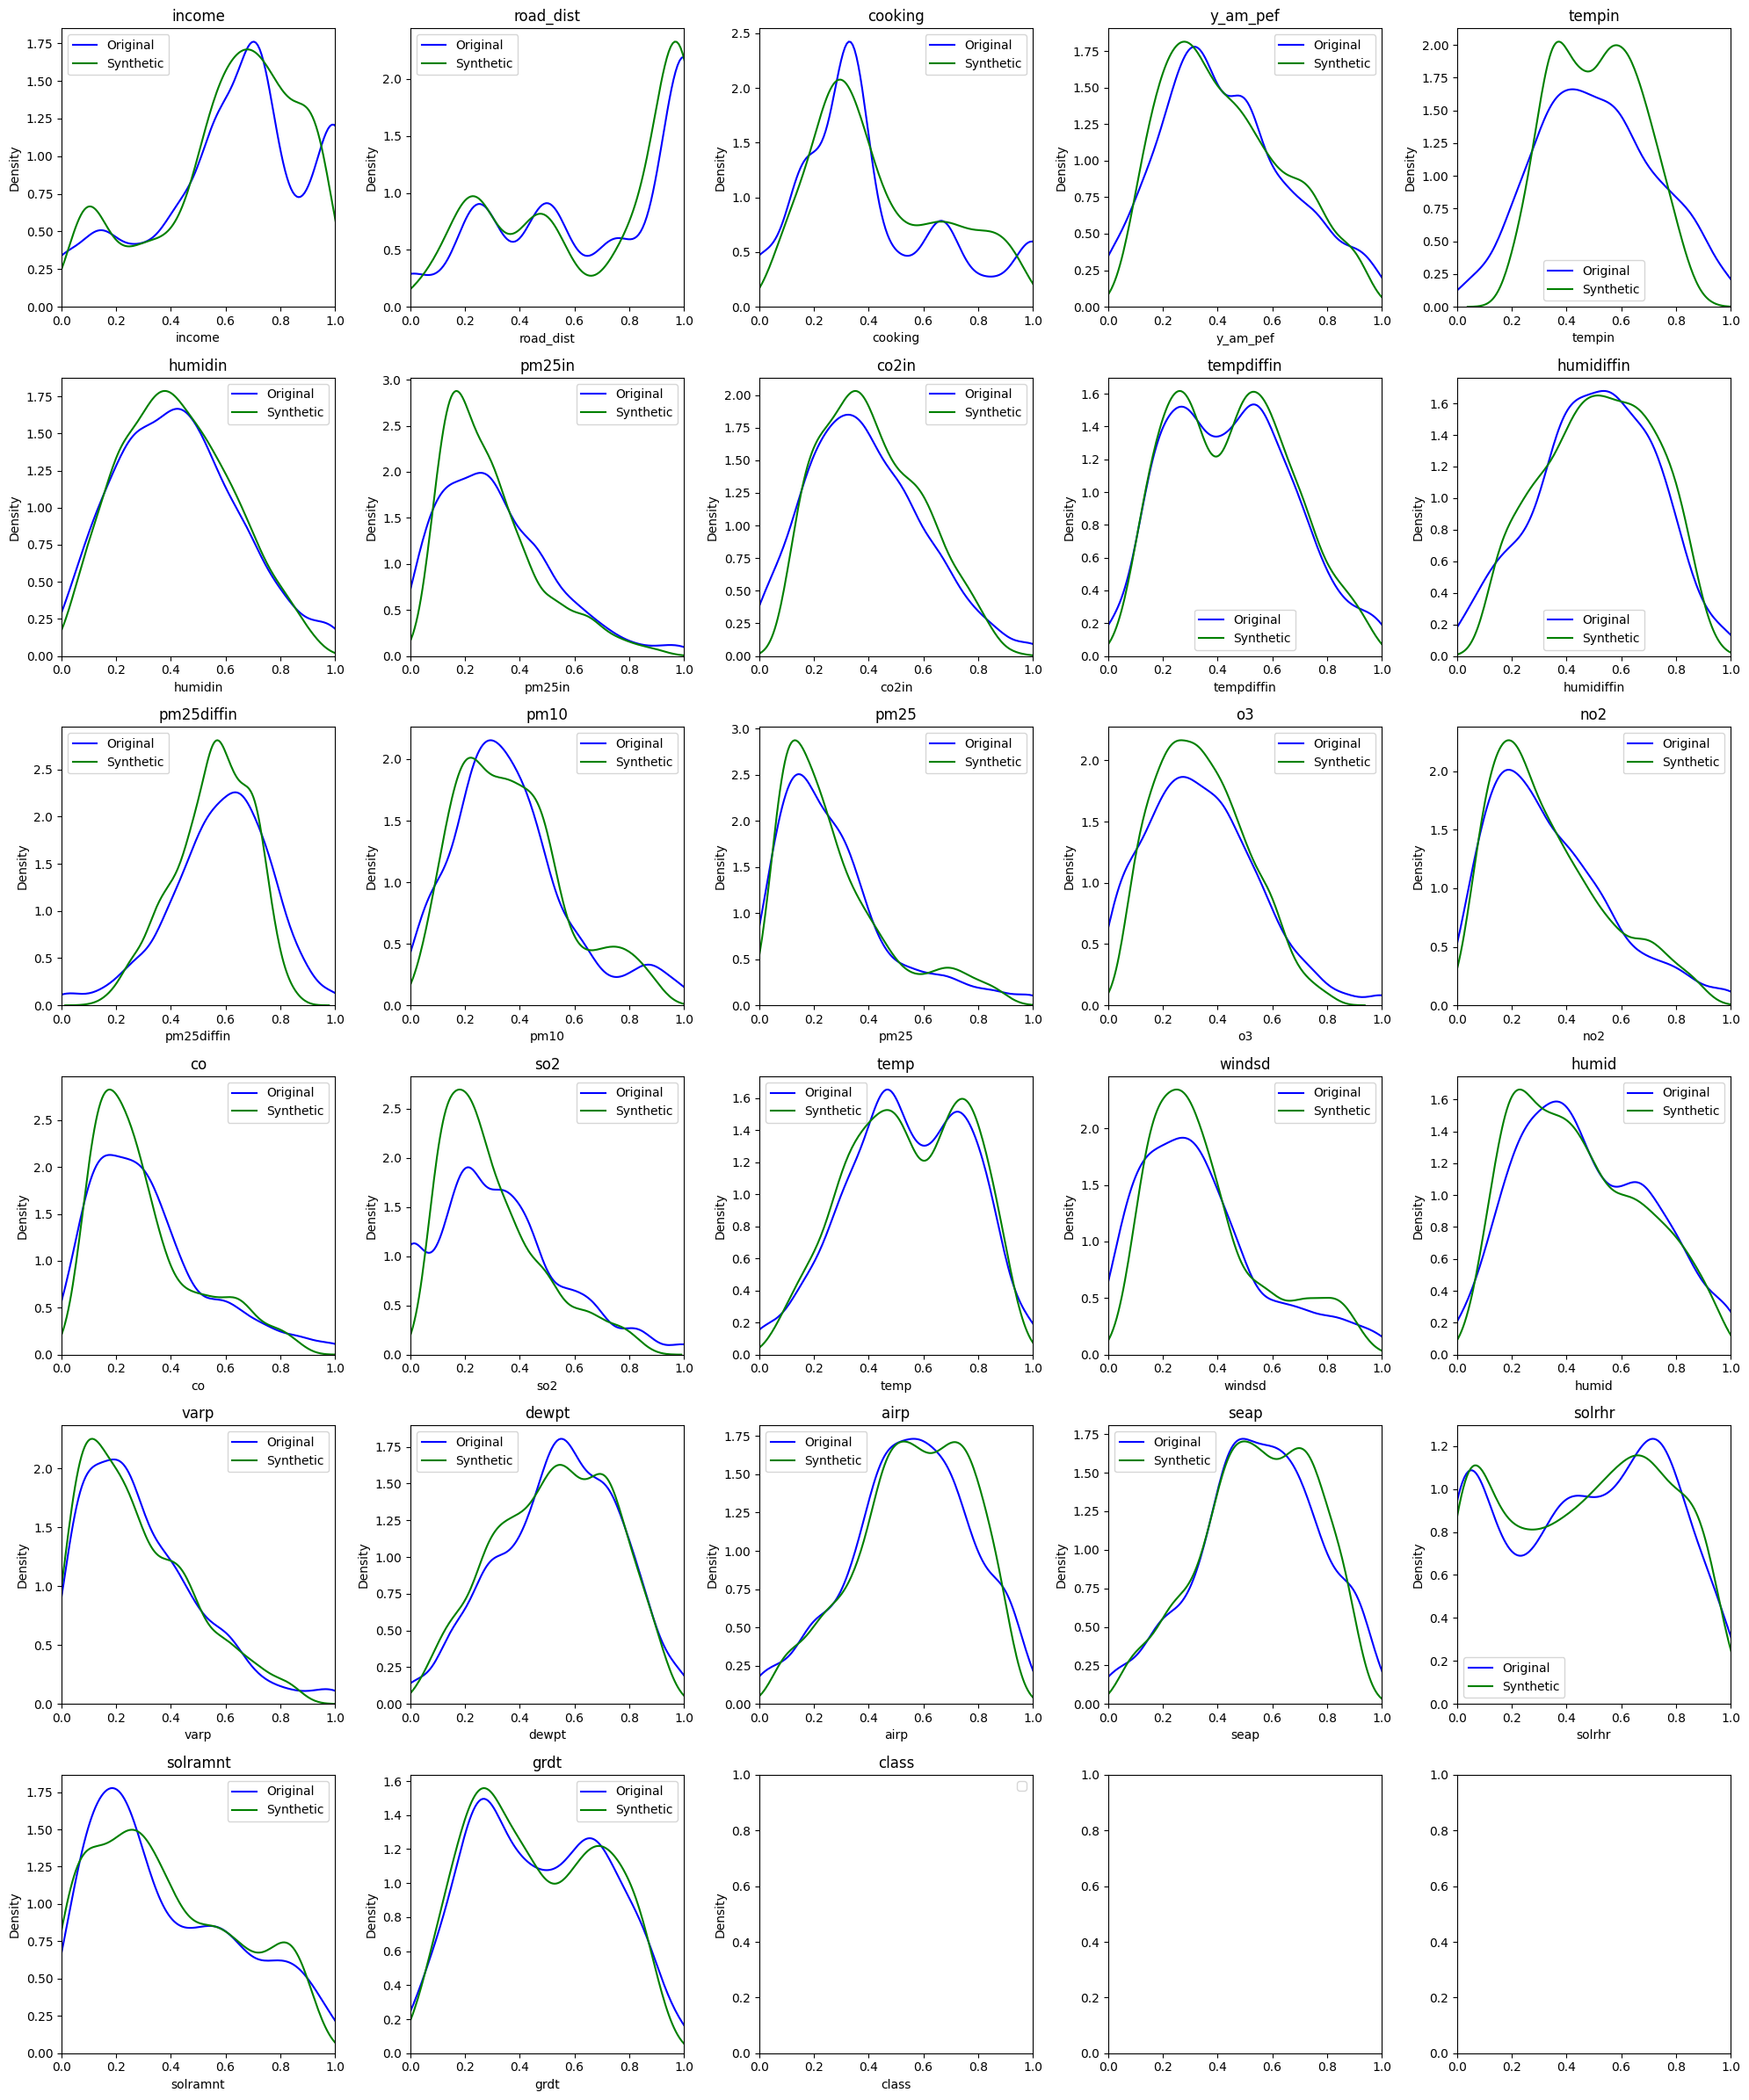

In [14]:
num_columns = len(df_generated.columns)
num_rows = int(np.ceil(num_columns / 5))
fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4 * num_rows))

for i, column in enumerate(X_train.columns):
    row = i // 5
    col = i % 5
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    sns.kdeplot(data=X_train[column], color='blue', label='Original', ax=ax)
    sns.kdeplot(data=df_generated[column], color='green', label='Synthetic', ax=ax)
    
    ax.set_title(column)
    ax.set_xlabel(column)
    ax.set_xlim(0, 1)
    
    ax.legend()

plt.tight_layout()
plt.show()

In [15]:
from gretel_client.evaluation.quality_report import QualityReport
from gretel_client import configure_session

pd.set_option("max_colwidth", None)
configure_session(api_key="prompt", cache="yes", validate=True)
# Load and preview real-world data
real_data = 'Original_minority_data.csv'
real_df = pd.read_csv(real_data)

synth_data = 'Synthetic_minority_data.csv'
synth_df = pd.read_csv(synth_data)

report = QualityReport(data_source=synth_data, ref_data=real_data)
report.run()
report.peek()

Config file C:\Users\sbhuv\.gretel\config.json is group- and/or world-readable!
Setting permissions to be readable by the owner only.
Config file C:\Users\sbhuv\.gretel\config.json is group- and/or world-readable!
Setting permissions to be readable by the owner only.
Config file C:\Users\sbhuv\.gretel\config.json is group- and/or world-readable!
Setting permissions to be readable by the owner only.


Found cached Gretel credentials
Using endpoint https://api.gretel.cloud
Logged in as sbhuvaj@gmail.com ✅


{'raw_score': 87.42962962962963, 'grade': 'Excellent', 'score': 87}

In [15]:
autoencoder.save('heavy_decoder_autoencoder.h5')